In [78]:
import pandas as pd
import gzip
import re
import seaborn as sns
import numpy as np
import math

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('omw-1.4') # For lemmatizer
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score, precision_score
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\barketr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\barketr\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\barketr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
def getDF(path):
    
    def parse(path):
        g = gzip.open(path, 'rb')
        for l in g:
            yield eval(l)
    
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [4]:
#Takes a few mins
toys_df = getDF('reviews_Toys_and_Games_5.json.gz')

In [5]:
vid_df = getDF('reviews_Video_Games_5.json.gz')

In [6]:
sport_df = getDF('reviews_Sports_and_Outdoors_5.json.gz')

In [7]:
vid_data = vid_df[vid_df['overall'] <= 2]
sport_data = sport_df[sport_df['overall'] <= 2]

In [152]:
df = pd.concat([toys_df, vid_data, sport_data])

In [153]:
df.shape

(215362, 9)

[Text(0.5, 0, 'Score'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Frequency of Review Scores from Amazon Toys and Games')]

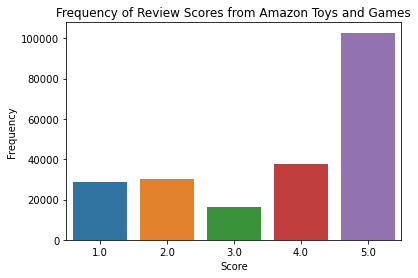

In [154]:
freq = sns.countplot(x='overall', data=df)
freq.set(xlabel='Score', ylabel='Frequency', title='Frequency of Review Scores from Amazon Toys and Games')

In [155]:
# Create 0/1 labels with 1 being negative sentiment
df = df.drop(df[df['overall']==3].index)
df['label'] = (df['overall'] <= 2).astype(int)

In [156]:
df['reviewText']

0         I like the item pricing. My granddaughter want...
1         Love the magnet easel... great for moving to d...
2         Both sides are magnetic.  A real plus when you...
3         Bought one a few years ago for my daughter and...
4         I have a stainless steel refrigerator therefor...
                                ...                        
295923    this item is bilt to cheaply i do not recomend...
295992    Materials and construction are ok, great for t...
296043    I have tried the ones sold in the home improve...
296050    Nope. Yet another disappointing &#34;cooling&#...
296156    These were a free sample for review.  I was ex...
Name: reviewText, Length: 196014, dtype: object

In [157]:
df['reviewText'][3]

'Bought one a few years ago for my daughter and she loves it, still using it today. For the holidays we bought one for our niece and she loved it too.'

In [158]:
stop_words = set(stopwords.words('english'))

In [159]:
def sanitize(s):
    
    s = s.lower()
    s = re.sub(r'[^A-Za-z0-9 ]+', '', s)
    s = ' '.join([word for word in s.split() if word not in (stop_words)])
    return s

In [160]:
san_reviews = df['reviewText'].apply(lambda s: sanitize(s))

In [161]:
wn = nltk.stem.WordNetLemmatizer()

In [162]:
def lemmatization(s):
    text_list = s.split()
    text_list = [wn.lemmatize(x) for x in text_list]
    text = " ".join(text_list)
    return text

In [163]:
san_reviews = san_reviews.apply(lambda s: lemmatization(s))

In [164]:
san_reviews[3]

'bought one year ago daughter love still using today holiday bought one niece loved'

## Number of unique words

In [21]:
import itertools
word_list = list(itertools.chain(san_reviews))

In [22]:
word_list = [word.split() for word in word_list]

In [23]:
rev_len = [len(word_list[i]) for i in range(len(word_list))]

# Average length of review
sum(rev_len)/len(rev_len)

56.848663870947995

In [22]:
word_list = [word for words in word_list for word in words]

In [23]:
import collections
counts = dict(collections.Counter(word_list))

In [24]:
count_df = pd.DataFrame.from_dict(counts, orient='index')
print(f'unique words: {len(count_df)}')
count_df.sort_values(by=0, inplace=True, ascending=False)
data = count_df[0:20]

unique words: 197319


<AxesSubplot:xlabel='word', ylabel='frequency'>

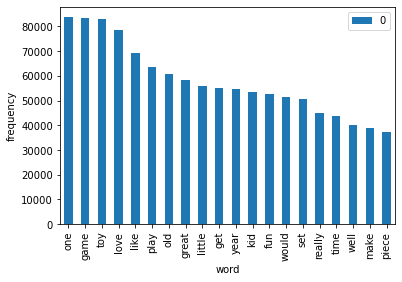

In [25]:
data.plot.bar(xlabel='word', ylabel='frequency')

## Model Set up

In [165]:
vocab_size = 4000 # choose based on statistics
embedding_dim = 100
max_length = 80 # Based on average length

In [166]:
#Compute class weight for unbalanced classes
cw = class_weight.compute_class_weight('balanced', classes=np.unique(df['label']), y=df['label'])
cw = {i: cw[i] for i in range(len(cw))}
cw

{0: 0.6988768852283667, 1: 1.7570591082665519}

In [167]:
X_train, X_test, y_train, y_test = train_test_split(san_reviews.values, df['label'].values, shuffle=True, stratify=df['label'].values)

In [168]:
X_train

array(['thought since month passed amazon would gotten photo description correct still paddlestyle mag pouch even though photo show one returned went bladetechthe build quality item pretty good inside pouch lined feltlike material mine arrived bunch scratch probably resold item paddle discrepancy',
       'sight held zero 50 yard fiber optic dot work well outdoors even cloudy day issue backup light bu used low light indoor condition first baffled switch marking backwards yes backwards really figured switch backward next issue backup light worked randomly would come hour later work next day would try would work frustrating since gun sight need reliable yes put brand new battery thing wish something middle 80 sight real 1100 acog sight also available amazon quality control better would exceptional value',
       'got puzzle amazon vine program review never done 3d puzzle excited try one outall piece numbered arrow know order put click together puzzle put together three section bottom tow

In [169]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)

In [170]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, padding='post', maxlen=max_length)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, padding='post', maxlen=max_length)

## BiLSTM

In [113]:
X_train.shape

(113430, 80)

In [171]:
bLSTM_model = keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64, dropout=0.2)),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
bLSTM_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[keras.metrics.Recall()],
            )

In [172]:
num_epochs = 5
history = bLSTM_model.fit(X_train, y_train, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1,
                    class_weight=cw)

Epoch 1/5
4135/4135 [==============================] - 268s 64ms/step - loss: 0.2067 - recall_14: 0.9101 - val_loss: 0.1790 - val_recall_14: 0.9310
Epoch 2/5
4135/4135 [==============================] - 269s 65ms/step - loss: 0.1561 - recall_14: 0.9352 - val_loss: 0.1668 - val_recall_14: 0.9374
Epoch 3/5
4135/4135 [==============================] - 255s 62ms/step - loss: 0.1342 - recall_14: 0.9459 - val_loss: 0.1555 - val_recall_14: 0.9280
Epoch 4/5
4135/4135 [==============================] - 266s 64ms/step - loss: 0.1146 - recall_14: 0.9551 - val_loss: 0.1760 - val_recall_14: 0.9435
Epoch 5/5
4135/4135 [==============================] - 256s 62ms/step - loss: 0.0976 - recall_14: 0.9631 - val_loss: 0.1639 - val_recall_14: 0.9242


In [173]:
results = bLSTM_model.predict(X_test)
results = [int(result>0.5) for result in results]

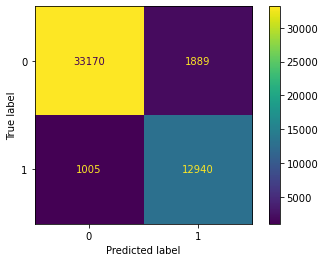

In [174]:
cm = confusion_matrix(y_test, results)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [175]:
print(accuracy_score(y_test, results))
print(precision_score(y_test, results))
print(recall_score(y_test, results))

0.9409435964411068
0.8726144716434014
0.9279311581211904


In [176]:
bLSTM_model.save('bLSTM1.h5')

## LSTM

In [140]:
LSTM_model = keras.Sequential([
    keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LSTM(36),
    keras.layers.Dense(1, activation='sigmoid')
])
# compile model
LSTM_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[keras.metrics.Recall()],
            )

In [141]:
num_epochs = 5
history = LSTM_model.fit(X_train, y_train, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1,
                    class_weight=cw)

Epoch 1/5
3191/3191 [==============================] - 186s 56ms/step - loss: 0.6358 - recall_12: 0.4727 - val_loss: 0.6601 - val_recall_12: 0.4372
Epoch 2/5
3191/3191 [==============================] - 173s 54ms/step - loss: 0.4931 - recall_12: 0.7427 - val_loss: 0.3308 - val_recall_12: 0.8345
Epoch 3/5
3191/3191 [==============================] - 178s 56ms/step - loss: 0.3122 - recall_12: 0.8657 - val_loss: 0.2506 - val_recall_12: 0.8261
Epoch 4/5
3191/3191 [==============================] - 170s 53ms/step - loss: 0.2506 - recall_12: 0.9075 - val_loss: 0.2580 - val_recall_12: 0.8527
Epoch 5/5
3191/3191 [==============================] - 171s 54ms/step - loss: 0.2093 - recall_12: 0.9309 - val_loss: 0.2281 - val_recall_12: 0.8297


In [177]:
LSTM_model = keras.models.load_model('pickles/LSTM1.h5')

In [184]:
results = LSTM_model.predict(X_test)

In [197]:
res = [int(result>0.40) for result in results]

In [198]:
cm

array([[19050, 16009],
       [ 3189, 10756]], dtype=int64)

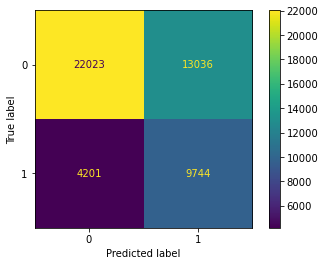

In [199]:
cm = confusion_matrix(y_test, res)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [183]:
print(accuracy_score(y_test, results))
print(precision_score(y_test, results))
print(recall_score(y_test, results))

0.669088237694882
0.44456378460186496
0.6529939046253137


In [145]:
LSTM_model.save('sparse_LSTM2.h5')

## RNN

In [146]:
RNN_model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.SimpleRNN(64, dropout=0.2, return_sequences=True),
    keras.layers.SimpleRNN(36, dropout=0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

RNN_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[keras.metrics.Recall()]
                 )

In [147]:
#65, 77
num_epochs = 5
RNNhistory = RNN_model.fit(X_train, y_train, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1,
                    class_weight=cw)

Epoch 1/5
3191/3191 [==============================] - 121s 37ms/step - loss: 0.7011 - recall_13: 0.4950 - val_loss: 0.7212 - val_recall_13: 0.6413
Epoch 2/5
3191/3191 [==============================] - 115s 36ms/step - loss: 0.6957 - recall_13: 0.5094 - val_loss: 0.7123 - val_recall_13: 0.8007
Epoch 3/5
3191/3191 [==============================] - 117s 37ms/step - loss: 0.6920 - recall_13: 0.4669 - val_loss: 0.6912 - val_recall_13: 0.4577
Epoch 4/5
3191/3191 [==============================] - 115s 36ms/step - loss: 0.6861 - recall_13: 0.4336 - val_loss: 0.6526 - val_recall_13: 0.2548
Epoch 5/5
3191/3191 [==============================] - 116s 37ms/step - loss: 0.6773 - recall_13: 0.3578 - val_loss: 0.6590 - val_recall_13: 0.3176


In [148]:
results = RNN_model.predict(X_test)
results = [int(result>0.5) for result in results]

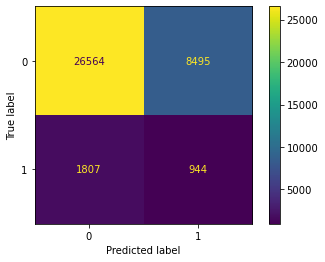

In [149]:
cm = confusion_matrix(y_test, results)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [150]:
print(accuracy_score(y_test, results))
print(precision_score(y_test, results))
print(recall_score(y_test, results))

0.7275323988362867
0.10001059434262104
0.34314794620138134


In [151]:
RNN_model.save('sparse_RNN2.h5')